# Running Injury Prediction
## Introduction
* https://www.kaggle.com/code/yehonam/running-injury-prediction
* https://dataverse.nl/file.xhtml?fileId=47762&version=1.0
......

## Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from photonai.base import Hyperpipe, PipelineElement, Preprocessing, Switch
from photonai.optimization import FloatRange, IntegerRange
from sklearn.model_selection import ShuffleSplit, GroupKFold, KFold, GroupShuffleSplit
from sklearn.model_selection import StratifiedGroupKFold

C:\Users\a1003\AppData\Local\Temp\ipykernel_36036\1966018641.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
week_df = pd.read_csv("C:/Users/a1003/OneDrive/桌面/Teaching/Machine learning applications in movement science/Dataset/running_injury_prediction_dataset/week_approach_maskedID_timeseries.csv")

## Data processing

In [3]:
def df_filtering(df, target_ID, target_col):
    target_ID = target_ID
    target_array = np.array(df[target_col])
    target_array = target_array.astype(str)

    # Check if any element contains any string in target_ID list
    result = [any(substring in element for substring in target_ID) for element in target_array]
    #result = np.core.defchararray.find(target_array, target_fall) != -1
    return df[result]

In [4]:
week_df.columns

Index(['nr. sessions', 'nr. rest days', 'total kms', 'max km one day',
       'total km Z3-Z4-Z5-T1-T2',
       'nr. tough sessions (effort in Z5, T1 or T2)',
       'nr. days with interval session', 'total km Z3-4',
       'max km Z3-4 one day', 'total km Z5-T1-T2', 'max km Z5-T1-T2 one day',
       'total hours alternative training', 'nr. strength trainings',
       'avg exertion', 'min exertion', 'max exertion', 'avg training success',
       'min training success', 'max training success', 'avg recovery',
       'min recovery', 'max recovery', 'nr. sessions.1', 'nr. rest days.1',
       'total kms.1', 'max km one day.1', 'total km Z3-Z4-Z5-T1-T2.1',
       'nr. tough sessions (effort in Z5, T1 or T2).1',
       'nr. days with interval session.1', 'total km Z3-4.1',
       'max km Z3-4 one day.1', 'total km Z5-T1-T2.1',
       'max km Z5-T1-T2 one day.1', 'total hours alternative training.1',
       'nr. strength trainings.1', 'avg exertion.1', 'min exertion.1',
       'max exertion.

In [5]:
week_drop_df = week_df.drop(['nr. sessions', 'nr. sessions.1', 'nr. sessions.2', 'Date',
                            'avg training success', 'min training success', 'max training success',
                            'avg training success.1', 'min training success.1', 'max training success.1',
                            'avg training success.2', 'min training success.2', 'max training success.2',
                             'rel total kms week 0_1','rel total kms week 0_2', 'rel total kms week 1_2'
                            ], axis = 1)
week_drop_df.head()

,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,max km Z5-T1-T2 one day,...,total hours alternative training.2,nr. strength trainings.2,avg exertion.2,min exertion.2,max exertion.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury
0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,0.6,...,0.0,1.0,0.09,0.08,0.10,0.18,0.16,0.20,0,0
1,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,0.5,...,0.0,1.0,0.10,0.08,0.10,0.18,0.16,0.20,0,0
2,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,0.5,...,0.0,0.0,0.10,0.10,0.10,0.17,0.16,0.18,0,0
3,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,0.5,...,0.0,1.0,0.11,0.10,0.12,0.18,0.16,0.18,0,0
4,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,0.5,...,0.0,1.0,0.11,0.10,0.12,0.17,0.16,0.18,0,0


## Data overview

In [6]:
week_drop_df.describe()

,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,max km Z5-T1-T2 one day,...,total hours alternative training.2,nr. strength trainings.2,avg exertion.2,min exertion.2,max exertion.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury
count,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,...,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000
mean,1.874667,49.543911,14.009255,9.433621,0.930184,1.672531,4.859398,3.456888,4.063970,2.725291,...,1.204381,0.824384,0.319983,0.187780,0.470030,0.255089,0.184927,0.343522,34.538249,0.013435
std,1.853287,36.715017,9.071678,8.887120,1.040631,1.263528,6.984670,4.577423,5.645305,3.547674,...,2.443005,0.997673,0.201807,0.151832,0.298909,0.153214,0.127996,0.219536,19.020826,0.115130
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,22.800000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.140000,0.090000,0.160000,0.150000,0.110000,0.170000,20.000000,0.000000
50%,1.000000,44.800000,13.400000,8.000000,1.000000,2.000000,0.000000,0.000000,1.500000,1.200000,...,0.000000,1.000000,0.320000,0.140000,0.510000,0.220000,0.160000,0.310000,34.000000,0.000000
75%,3.000000,70.100000,18.300000,14.600000,2.000000,3.000000,8.000000,6.300000,6.300000,5.000000,...,1.580000,1.000000,0.490000,0.270000,0.730000,0.360000,0.240000,0.520000,50.000000,0.000000
max,7.000000,242.000000,131.000000,100.000000,6.000000,7.000000,79.800000,75.000000,80.000000,76.000000,...,67.330000,9.000000,0.980000,0.980000,1.000000,0.900000,0.900000,1.000000,73.000000,1.000000


In [7]:
ID_list = week_drop_df["Athlete ID"].unique()
total_ID_count = len((ID_list ))
print("Total amount of subjects: {}".format(total_ID_count))

Total amount of subjects: 74


<Axes: >

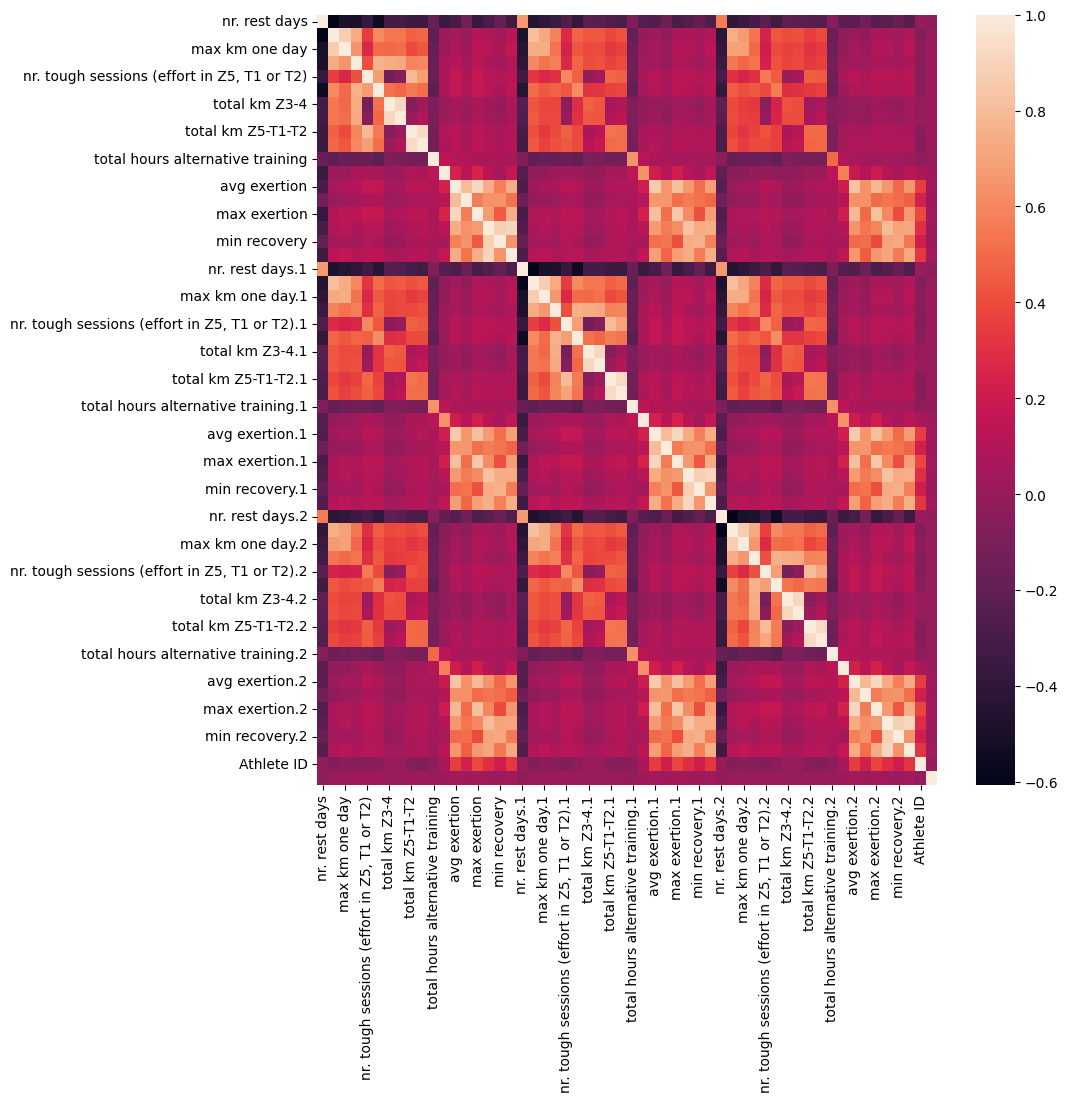

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(week_drop_df.corr())

In [9]:
bar_plot_list = week_drop_df.columns[:18]
len(bar_plot_list)

18

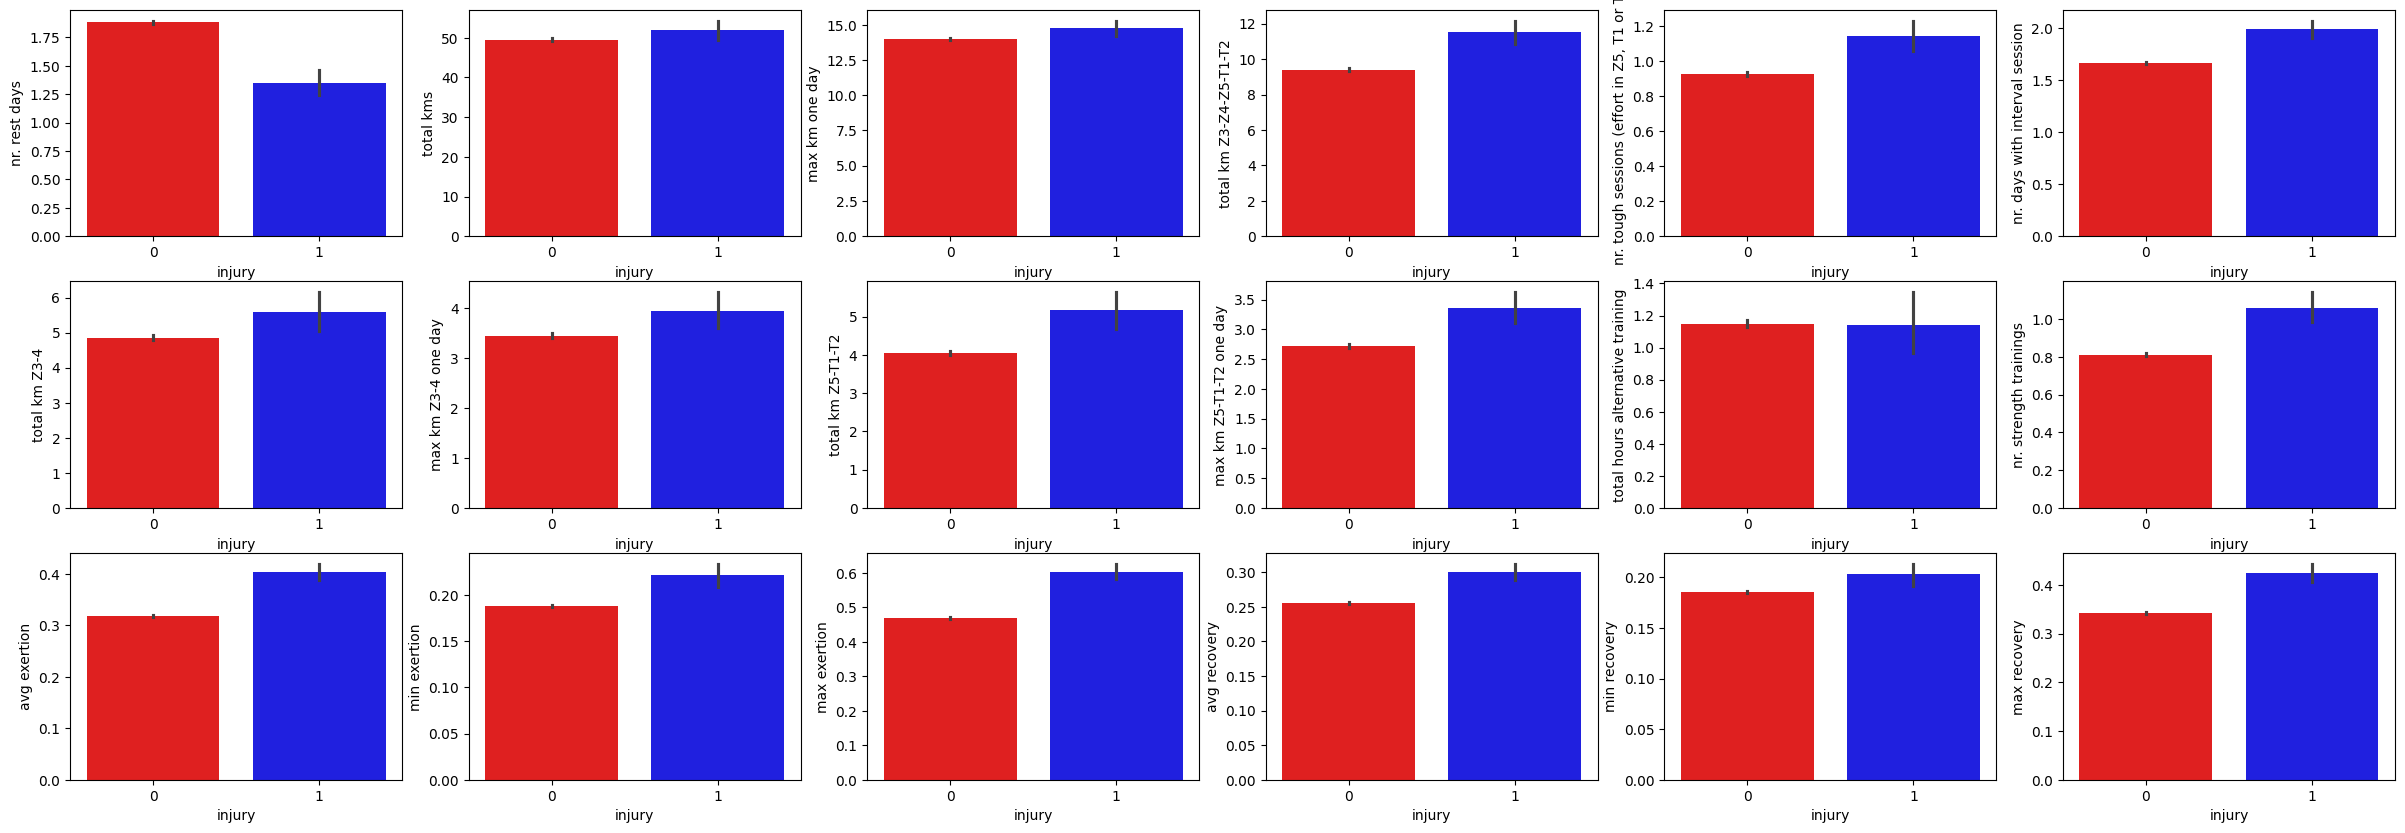

In [24]:
fig, axes = plt.subplots(3, 6, figsize=(30, 10))

count = 0
for row in range(3):
    for col in range(6):        
        sns.barplot(ax=axes[row, col], data = week_drop_df, x = "injury", y = bar_plot_list[count], palette = ["red", "blue"])
        count = count + 1


In [11]:
week_drop_df[week_drop_df["injury"]==1]["Athlete ID"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 40,
       41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 61, 63, 64, 65, 67, 68, 69, 70, 71], dtype=int64)

In [12]:
week_drop_df[week_drop_df["injury"]==0]["Athlete ID"].unique()
# 11, 12, 15, 30, 31, 46, 60, 62, 66, 72, 73

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73], dtype=int64)

In [13]:
df_filtering(df = week_drop_df, target_ID = ["11", "12", "15", "30", "31", "46", "60", "62", "66", "72", "73"], target_col = "Athlete ID")

,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,max km Z5-T1-T2 one day,...,total hours alternative training.2,nr. strength trainings.2,avg exertion.2,min exertion.2,max exertion.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury
5942,0.0,103.0,19.3,25.5,3.0,3.0,0.0,0.0,25.0,10.0,...,0.00,0.0,0.13,0.11,0.15,0.16,0.15,0.17,11,0
5943,0.0,97.8,19.3,25.5,3.0,3.0,0.0,0.0,25.0,10.0,...,0.02,0.0,0.14,0.11,0.15,0.16,0.14,0.17,11,0
5944,0.0,98.8,19.3,25.5,3.0,3.0,0.0,0.0,25.0,10.0,...,0.12,0.0,0.14,0.11,0.16,0.15,0.14,0.16,11,0
5945,0.0,93.3,18.0,25.5,3.0,3.0,0.0,0.0,25.0,10.0,...,0.13,0.0,0.14,0.12,0.16,0.15,0.14,0.17,11,0
5946,0.0,96.1,19.5,23.8,3.0,3.0,0.0,0.0,23.2,10.0,...,0.15,0.0,0.15,0.12,0.17,0.15,0.14,0.17,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42218,1.0,72.0,14.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.24,0.06,0.62,0.12,0.06,0.27,73,0
42219,0.0,86.3,14.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.24,0.06,0.62,0.12,0.06,0.27,73,0
42220,0.0,90.3,14.7,4.8,1.0,1.0,0.0,0.0,4.8,4.8,...,0.00,0.0,0.34,0.06,0.76,0.14,0.06,0.27,73,0
42221,1.0,75.6,14.3,4.8,1.0,1.0,0.0,0.0,4.8,4.8,...,0.00,0.0,0.40,0.06,0.76,0.14,0.06,0.27,73,0


In [14]:
# balance the dataset
## 575 injury data points
week_drop_balance_df = week_drop_df.iloc[-1150:]
non_injured_df = df_filtering(df = week_drop_df, 
                         target_ID = ["11", "12", "15", "30", "31", "46", "60", "62", "66", "72", "73"], 
                         target_col = "Athlete ID")
shuffle_non_injured_df = shuffle(non_injured_df)
non_injured_balance_df = shuffle_non_injured_df.iloc[:575]
non_injured_ID = non_injured_balance_df["Athlete ID"].unique()

injured_df = week_drop_df[week_drop_df["injury"]==1]
injured_ID = injured_df["Athlete ID"].unique()


print("injury_ID: {} \n non_injured_ID: {}".format(injured_ID, non_injured_ID))
print("injury_df_len: {} \n non_injured_df_len: {}".format(len(non_injured_balance_df), len(injured_df)))

injury_ID: [ 0  1  2  3  4  5  6  7  8  9 10 13 14 16 17 18 19 20 21 22 23 24 26 27
 28 29 32 33 34 35 36 37 38 40 41 42 43 44 45 47 48 49 50 51 52 53 54 55
 56 57 58 59 61 63 64 65 67 68 69 70 71] 
 non_injured_ID: [12 72 62 46 11 60 30 66 73 15 31]
injury_df_len: 575 
 non_injured_df_len: 575


In [15]:
balance_df = pd.concat([non_injured_balance_df, injured_df], ignore_index=True)
balance_df

,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,max km Z5-T1-T2 one day,...,total hours alternative training.2,nr. strength trainings.2,avg exertion.2,min exertion.2,max exertion.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury
0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.0,0.10,0.10,0.10,0.06,0.06,0.06,12,0
1,1.0,60.0,19.0,9.0,1.0,1.0,0.0,0.0,9.0,9.0,...,0.00,0.0,0.35,0.14,0.51,0.16,0.13,0.19,72,0
2,2.0,51.5,13.0,13.5,1.0,2.0,9.0,9.0,4.5,4.5,...,0.17,2.0,0.40,0.11,0.71,0.15,0.00,0.26,62,0
3,1.0,76.2,18.8,9.4,2.0,2.0,0.0,0.0,9.4,6.4,...,0.00,1.0,0.49,0.33,0.64,0.52,0.45,0.57,46,0
4,0.0,82.4,19.1,25.1,2.0,3.0,12.0,12.0,13.1,8.0,...,0.00,2.0,0.25,0.15,0.44,0.18,0.18,0.19,72,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,3.0,59.5,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.50,0.06,0.92,0.20,0.12,0.26,71,1
1146,6.0,5.8,5.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.19,0.19,0.19,0.12,0.12,0.12,71,1
1147,4.0,38.3,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.50,0.32,0.68,0.32,0.17,0.62,71,1
1148,2.0,67.0,15.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.55,0.30,0.80,0.28,0.22,0.41,71,1


In [16]:
X_df = balance_df.drop(["Athlete ID", "injury"], axis =1)
Y_df = balance_df["injury"]

## Train and test a ML model

In [17]:
#X_train, X_test, y_train, y_test = train_test_split(np.array(X_df), np.array(Y_df), test_size=0.2, random_state=42)

In [18]:
# Specify how results are going to be saved
# Define hyperpipe
hyperpipe = Hyperpipe(name = "injurypredictionproject",
                      project_folder = 'injuryprediction',
                      optimizer="random_grid_search",
                      optimizer_params={'n_configurations': 30},
                      metrics=['accuracy', 'sensitivity', 'specificity'],
                      best_config_metric ='balanced_accuracy',
                      outer_cv = KFold(n_splits=5,shuffle=True),
                      inner_cv = ShuffleSplit(n_splits=3, test_size=0.2)
                     )
        
# Add transformer elements
hyperpipe += PipelineElement("StandardScaler", hyperparameters={}, 
                             test_disabled=False, with_mean=True, with_std=True)
# Add estimator
estimator_switch = Switch('EstimatorSwitch')
estimator_switch += PipelineElement("SVC", hyperparameters={'C': FloatRange(0.5, 2), 'kernel': ['linear', 'rbf']}, gamma='scale', max_iter=1000000)
estimator_switch += PipelineElement("RandomForestClassifier", hyperparameters={'n_estimators': IntegerRange(5, 20), 'min_samples_split': IntegerRange(2,5), 'min_samples_leaf': IntegerRange(1,3)}, criterion='gini', max_depth=None)
hyperpipe += estimator_switch

In [20]:
try:
    hyperpipe.fit(np.array(X_df), np.array(Y_df))
except Exception:
    pass

PHOTONAI ANALYSIS: injurypredictionproject
Found 2 target classes: [0 1]

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
+-------------------+--------+
| PERFORMANCE DUMMY |        |
+-------------------+--------+
|      accuracy     | 0.4783 |
|    sensitivity    | 0.0000 |
|    specificity    | 1.0000 |
| balanced_accuracy | 0.5000 |
+-------------------+--------+
-----------------------------------------------------------------------------------------------------
BEST_CONFIG 
-----------------------------------------------------------------------------------------------------
{
    "EstimatorSwitch": [
        "{'RandomForestClassifier__min_samples_leaf': 1, 'RandomForestClassifier__min_samples_split': 4, 'RandomForestClassifier__n_estimators': 19}"
    ]
}
------------------------------------------

-----------------------------------------------------------------------------------------------------
+-------------------+-------------------+------------------+
|       METRIC      | PERFORMANCE TRAIN | PERFORMANCE TEST |
+-------------------+-------------------+------------------+
|      accuracy     |       0.9914      |      0.9293      |
|    sensitivity    |       0.9882      |      0.9129      |
|    specificity    |       0.9946      |      0.9448      |
| balanced_accuracy |       0.9914      |      0.9289      |
+-------------------+-------------------+------------------+
-----------------------------------------------------------------------------------------------------
TEST PERFORMANCE
-----------------------------------------------------------------------------------------------------
+-------------------+-------------------+------------------+
|       METRIC      | PERFORMANCE TRAIN | PERFORMANCE TEST |
+-------------------+-------------------+------------------+
|     

In [ ]:
hyperpipe.predict()